In [65]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
from sklearn.utils import shuffle
from tensorflow.metrics import F1Score
import numpy as np
import os
import cv2
import tensorflow.keras.backend as K


import wandb
from wandb.keras import WandbCallback

ModuleNotFoundError: No module named 'tensorflow.metrics'

In [3]:
DATADIR = "data/Training/"
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
IMG_SIZE = 70
training_data = []

for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
        training_data.append([new_array,class_num])



In [4]:
DATADIR = "data/Testing/"
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
IMG_SIZE = 70
testing_data = []

for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
        testing_data.append([new_array,class_num])


In [26]:
wandb.login()



wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [38]:
test_X = []
test_y = []

for image, label in testing_data:
    test_X.append(image)
    test_y.append(label)

test_X = np.array(test_X).reshape(-1,IMG_SIZE,IMG_SIZE)
test_X = test_X/127.0 - 1
test_X = test_X.reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = np.array(test_y)

test_X, test_y = shuffle(test_X, test_y)

In [39]:
train_X = []
train_y = []

for image, label in training_data:
    train_X.append(image)
    train_y.append(label)

train_X = np.array(train_X).reshape(-1,IMG_SIZE,IMG_SIZE)
train_X = train_X/127.0 - 1
train_X = train_X.reshape(-1,IMG_SIZE,IMG_SIZE,1)
train_y = np.array(train_y)

train_X, train_y = shuffle(train_X, train_y)

In [58]:
def get_f1(y_true, y_pred): #taken from old keras source code
    print(y_true)
    print(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
    #f1_score(y_true, y_pred)

In [59]:
get_f1([1,0,1], [1,1,1])

[1, 0, 1]
[1, 1, 1]


TypeError: can't multiply sequence by non-int of type 'list'

In [47]:
config = {
    "epochs": 10,
    "batch_size": 32,
    "dropout": 0,
    "loss_function": "sparse_categorical_crossentropy",
    "optimizer": "Adam",
    "dataset": "wine quality"
}

run = wandb.init(project='nsfitt-pa', entity='nsfitt-pa')
wandb.config.update(config)

wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [60]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(70, 70, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation = "softmax"))

model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(),
              metrics=[get_f1, 'accuracy'])

my_callbacks = [
    WandbCallback(monitor='val_loss', mode='min', save_model=True)
]

history = model.fit(train_X, train_y, batch_size=config['batch_size'], epochs=config['epochs'], validation_split=0.2, callbacks=my_callbacks)

Epoch 1/10
Tensor("Cast_1:0", shape=(None, 1), dtype=float32)
Tensor("sequential_9/dense_19/Softmax:0", shape=(None, 4), dtype=float32)
Tensor("Cast_1:0", shape=(None, 1), dtype=float32)
Tensor("sequential_9/dense_19/Softmax:0", shape=(None, 4), dtype=float32)
92/92 [==============================] - ETA: 0s - loss: 1.1068 - get_f1: 2.4838 - accuracy: 0.4946Tensor("Cast_1:0", shape=(None, 1), dtype=float32)
Tensor("sequential_9/dense_19/Softmax:0", shape=(None, 4), dtype=float32)
92/92 [==============================] - 9s 94ms/step - loss: 1.1045 - get_f1: 2.4759 - accuracy: 0.4960 - val_loss: 0.6195 - val_get_f1: 1.1414 - val_accuracy: 0.7650
Epoch 2/10
92/92 [==============================] - 8s 87ms/step - loss: 0.5683 - get_f1: 1.0700 - accuracy: 0.7732 - val_loss: 0.4878 - val_get_f1: 0.9932 - val_accuracy: 0.7923
Epoch 3/10
92/92 [==============================] - 8s 90ms/step - loss: 0.4070 - get_f1: 0.9528 - accuracy: 0.8399 - val_loss: 0.4724 - val_get_f1: 1.0209 - val_accura

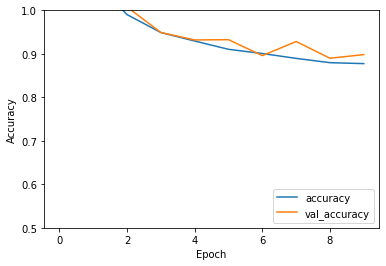

In [43]:
plt.plot(history.history['get_f1'], label='accuracy')
plt.plot(history.history['val_get_f1'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [44]:
y_pred = model.predict(test_X)
y_pred = np.argmax(y_pred,axis=1)

In [45]:
from sklearn.metrics import classification_report,confusion_matrix

clf_report = classification_report(test_y,y_pred, target_names=CATEGORIES, output_dict=True)
clf_report_str = classification_report(test_y,y_pred, target_names=CATEGORIES)
print(clf_report)
print(clf_report_str)

{'glioma_tumor': {'precision': 0.8947368421052632, 'recall': 0.17, 'f1-score': 0.2857142857142857, 'support': 100}, 'meningioma_tumor': {'precision': 0.6903225806451613, 'recall': 0.9304347826086956, 'f1-score': 0.7925925925925925, 'support': 115}, 'no_tumor': {'precision': 0.5777777777777777, 'recall': 0.9904761904761905, 'f1-score': 0.7298245614035088, 'support': 105}, 'pituitary_tumor': {'precision': 0.925, 'recall': 0.5, 'f1-score': 0.6491228070175439, 'support': 74}, 'accuracy': 0.6725888324873096, 'macro avg': {'precision': 0.7719593001320506, 'recall': 0.6477277432712215, 'f1-score': 0.6143135616819828, 'support': 394}, 'weighted avg': {'precision': 0.7562879382014887, 'recall': 0.6725888324873096, 'f1-score': 0.6202696532645772, 'support': 394}}
                  precision    recall  f1-score   support

    glioma_tumor       0.89      0.17      0.29       100
meningioma_tumor       0.69      0.93      0.79       115
        no_tumor       0.58      0.99      0.73       105
 pi

In [46]:

wandb.log({'Accuracy_test': clf_report['accuracy']})
wandb.log({'glioma_tumor_f1': clf_report['glioma_tumor']['f1-score']})
wandb.log({'meningioma_tumor_f1': clf_report['meningioma_tumor']['f1-score']})
wandb.log({'no_tumor_f1': clf_report['no_tumor']['f1-score']})
wandb.log({'pituitary_tumor_f1': clf_report['pituitary_tumor']['f1-score']})
run.finish()


epoch,9
loss,0.05225
get_f1,0.87753
accuracy,0.98531
val_loss,0.35356
val_get_f1,0.89823
val_accuracy,0.91393
_runtime,169
_timestamp,1617705050
_step,14
best_val_loss,0.33371


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
get_f1,█▂▂▁▁▁▁▁▁▁
accuracy,▁▄▅▆▆▇▇███
val_loss,█▄▄▂▂▁▁▁▂▁
val_get_f1,█▃▃▂▂▂▁▂▁▁
val_accuracy,▁▃▄▅▆▆█▇██
_runtime,▁▁▂▂▂▃▃▄▄▄█████
_timestamp,▁▁▂▂▂▃▃▄▄▄█████
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Accuracy_test,▁


In [ ]:
# plt.style.use("ggplot")
# plt.figure(figsize=(12,6))
# epochs = range(1,16)
# plt.subplot(1,2,1)
# plt.plot(epochs,history.history["accuracy"],'go-')
# plt.plot(epochs,history.history["val_accuracy"],'ro-')
# plt.title("Model Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend(['Train','Val'],loc = "upper left")

# plt.subplot(1,2,2)
# plt.plot(epochs,history.history["loss"],'go-')
# plt.plot(epochs,history.history["val_loss"],'ro-')
# plt.title("Model Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend(['Train','Val'],loc = "upper left")

# plt.show()